<a href="https://colab.research.google.com/github/Santiago-Quinteros/RNN_RecurrentNeuralNetworks_TP/blob/main/RNN_RecurrentNeuralNetworks_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab session 6: Recurrent Neural Networks (RNN)

Authors: [pierre.tandeo@imt-atlantique.fr](pierre.tandeo@imt-atlantique.fr), [lucas.drumetz@imt-atlantique.fr](lucas.drumetz@imt-atlantique.fr), [claire.scavinner-dorval@imt-atlantique.fr](claire.scavinner-dorval@imt-atlantique.fr), [sarah.reynaud@imt-atlantique.fr](sarah.reynaud@imt-atlantique.fr), [hugo.georgenthum@imt-atlantique.fr](hugo.georgenthum@imt-atlantique.fr)

Year: 2023-2024

Student 1: QUINTEROS Santiago

Student 2: PISTONE W. Sofia

In this practice, we will use a Recurrent Neural Networks (RNN) to fit multivariate time series and to make some predictions in the future. We will use the Lorenz-63 chaotic model, also known as the strange attractor (see https://en.wikipedia.org/wiki/Lorenz_system for more details).

First, we will generate and visualize trajectories from the Lorenz-63 system. From these data, we will build training and test datasets. Then, we will adjust two models to fit the data: a classic linear autoregressive model and the specific LSTM (Long Short-Term Memory) architecture of RNN. Finally, we will compare these models in terms of prediction and simulation of new trajectories.

In [ ]:
# Import libraries
%pylab inline
%matplotlib inline

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# Parameters (figure size)
pylab.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


**A few words about the use of GPUs**

In order to accelerate the optimization of your LSTM, we suggest to use GPUs. In Google Colab, you will need to enable GPUs for the notebook:
* navigate to Edit → Notebook Settings
* select GPU from the Hardware Accelerator drop-down

Then, the use of GPU in PyTorch is based on four steps:
* declare the GPU device (cell below)
* transfer the training data to the GPU
* use the GPU to learn the model
* transfer the results to the CPU

You will find more explanations here: https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99.

In [ ]:
# Declare the GPU (its name is "device")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Generate data**

Below, we define the 3-dimensional Lorenz-63 model given by:
\begin{aligned}{\frac {\mathrm {d} x_1}{\mathrm {d} t}}&=\sigma (x_2-x_1),\\[6pt]{\frac {\mathrm {d} x_2}{\mathrm {d} t}}&=x_1(\rho -x_3)-x_2,\\[6pt]{\frac {\mathrm {d} x_3}{\mathrm {d} t}}&=x_1 x_2-\beta x_3.\end{aligned}

This ordinary differential equation is using 3 physical parameters and we fix them to $\sigma=10$, $\rho=28$ and $\beta=8/3$. Then, we use Runge-Kutta 4-5 to integrate the model, using the *odeint()* Python function. The integration time is $0.01$ and we generate a sequence of $100$ Lorenz times.

In [ ]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [ ]:
from scipy.integrate import odeint

# Define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.01 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# Generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma,rho,beta))
time = arange(0.01,T,dt)

# Transform array to tensor
x = torch.from_numpy(x).float()


**Visualize data**

They are 2 ways of visualizing the Lorenz-63 system. The first is to consider the system as a 3-dimensional time series: we plot each variable as a function of time. The second is the phase-space representation where we plot the relationships between variables in 3D and we track the trajectory along time.

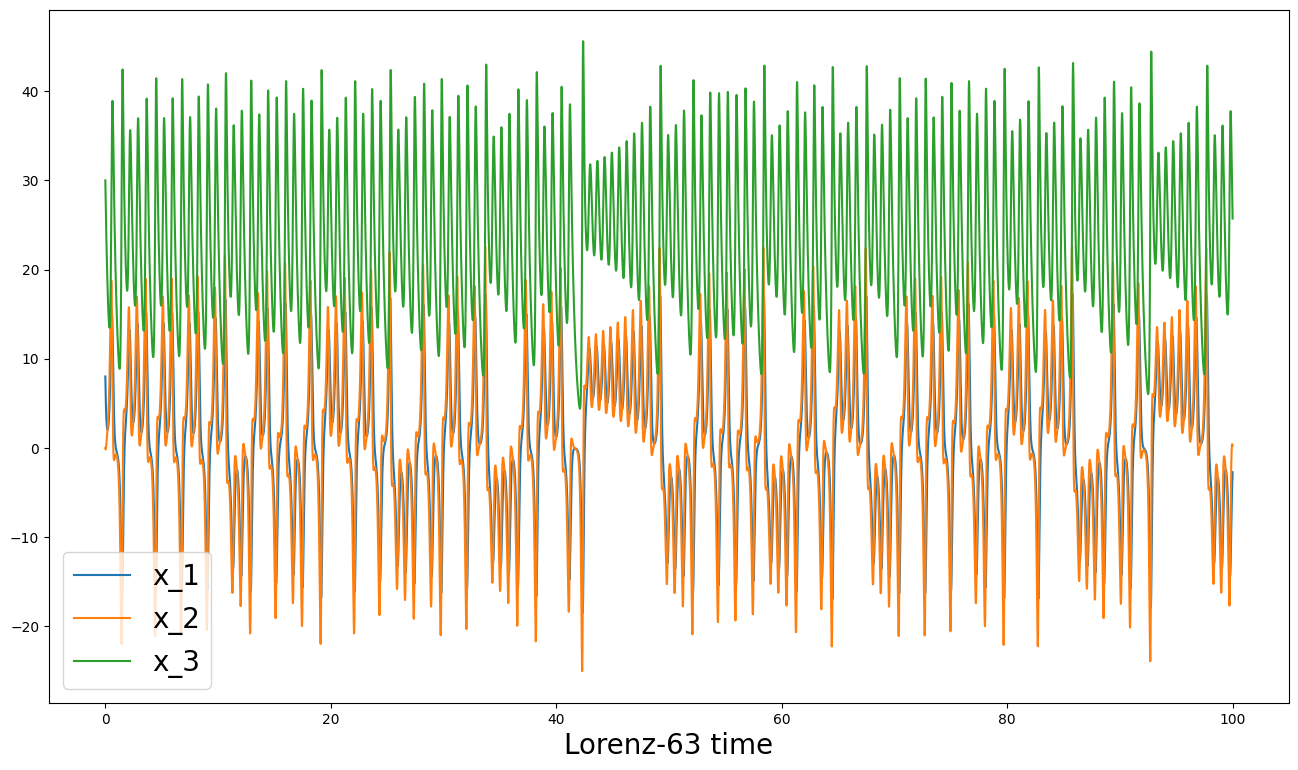

In [ ]:
# Time series representation
plot(time, x)
xlabel('Lorenz-63 time', size=20)
legend(['x_1','x_2','x_3'], fontsize=20)

**Create the training and test datasets**

Here, we want to predict the Lorenz-63 system at time t using the previous information at time t-0.01. It is thus a regression between the process and himself with a time delay. Here, we create a training (the first 2/3 of time series) and a test dataset (the last part).

In [ ]:
# Size of the training set
T_train = int(T/dt*2/3)

# Training set
x_train = x[0:T_train,:]
y_train = x[1:T_train+1,:]

# Validation set
x_test = x[T_train+1:-1,]
y_test = x[T_train+2:,]

**Question 1:**

For the 3 components of the Lorenz-63 system, plot *y_train* as a function of *x_train* and comment the relationship. What is happening if we increase the time delay (currently set to $0.01$) between *x_train* and *y_train*?

In [ ]:
# Change the time delay value
dt = 0.1
x_1 = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma,rho,beta))
time_1 = arange(0.01,T,dt)

# Transform array to tensor
x_1 = torch.from_numpy(x_1).float()

# Size of the training set
T_train_1 = int(T/dt*2/3)

# Training set
x_train_1 = x_1[0:T_train_1,:]
y_train_1 = x_1[1:T_train_1+1,:]

# Validation set
x_test_1 = x_1[T_train_1+1:-1,]
y_test_1 = x_1[T_train_1+2:,]


dt = 1
x_2 = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma,rho,beta))
time_2 = arange(0.01,T,dt)

# Transform array to tensor
x_2 = torch.from_numpy(x_2).float()

# Size of the training set
T_train_2 = int(T/dt*2/3)

# Training set
x_train_2 = x_2[0:T_train_2,:]
y_train_2 = x_2[1:T_train_2+1,:]

# Validation set
x_test_2 = x_2[T_train_2+1:-1,]
y_test_2 = x_2[T_train_2+2:,]




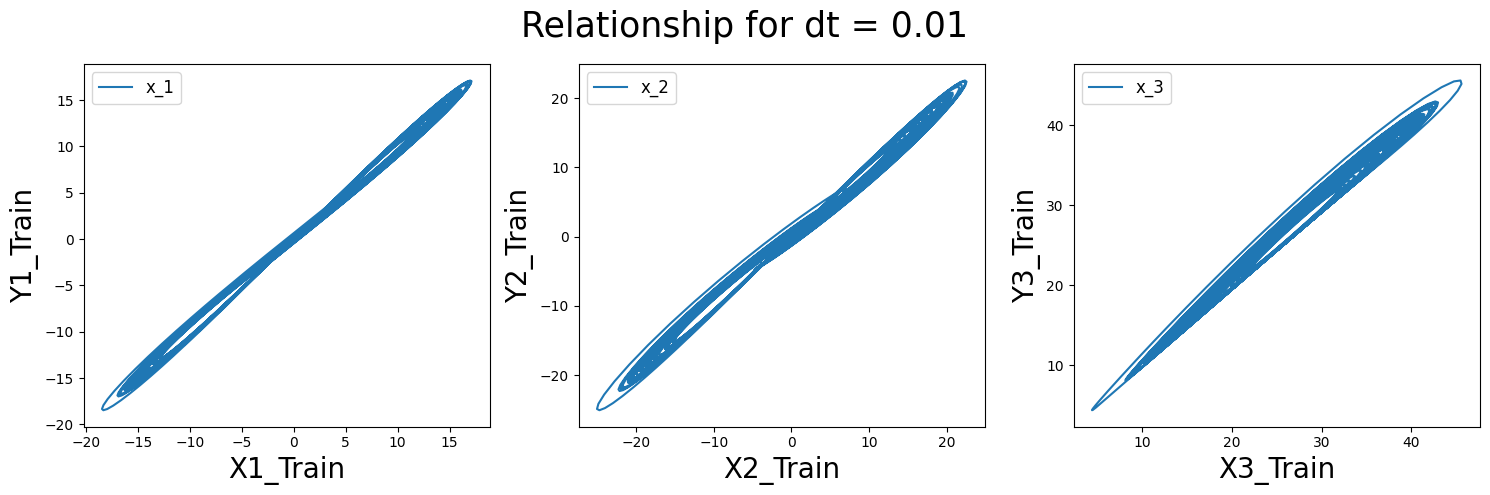

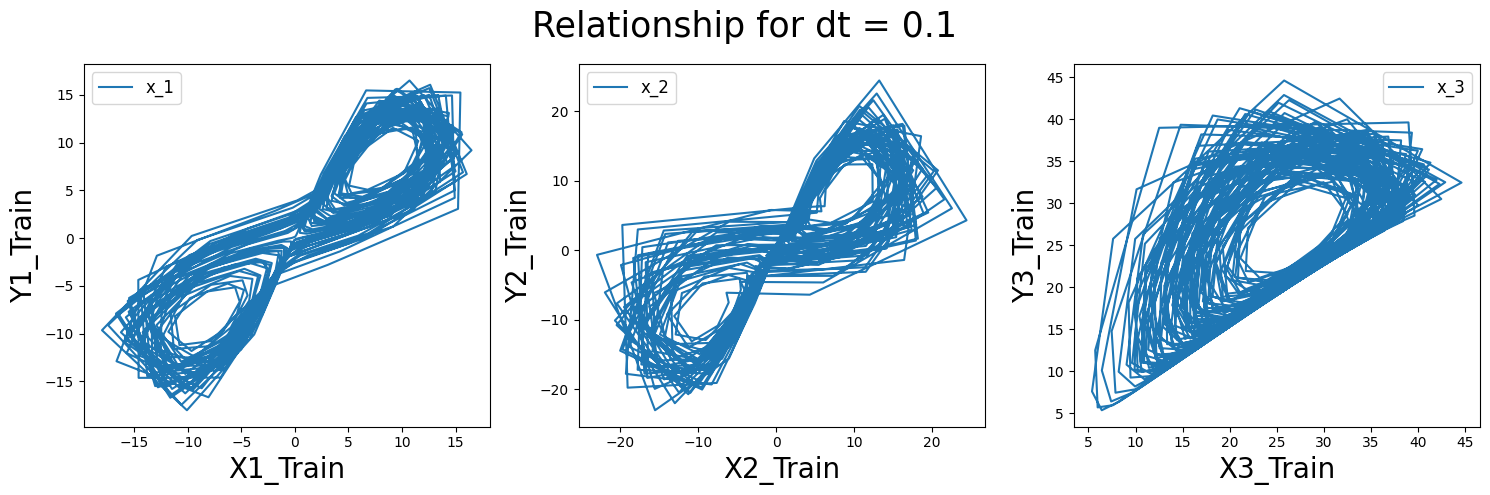

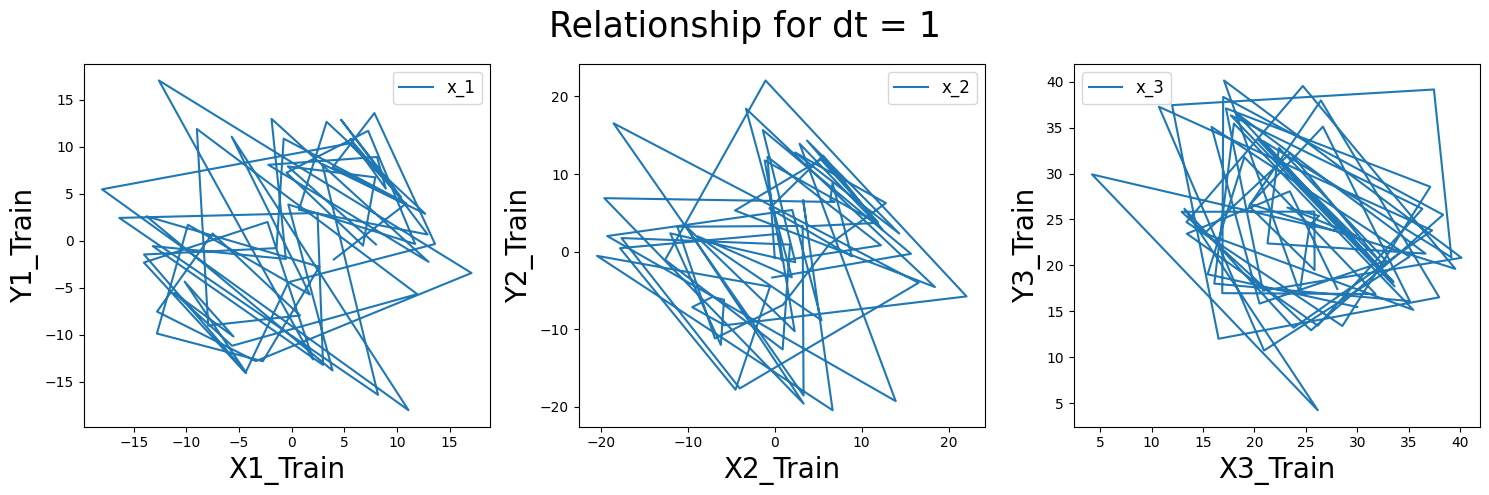

In [ ]:
# Plot
# dt = 0.01
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].plot(x_train[:, i], y_train[:, i])
    axs[i].set_xlabel(f'X{i + 1}_Train', size=20)
    axs[i].set_ylabel(f'Y{i + 1}_Train', size=20)
    axs[i].legend([f'x_{i + 1}'], fontsize=12)
plt.suptitle('Relationship for dt = 0.01', size=25)
plt.tight_layout()
plt.show()

# dt = 0.1
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].plot(x_train_1[:, i], y_train_1[:, i])
    axs[i].set_xlabel(f'X{i + 1}_Train', size=20)
    axs[i].set_ylabel(f'Y{i + 1}_Train', size=20)
    axs[i].legend([f'x_{i + 1}'], fontsize=12)

plt.suptitle('Relationship for dt = 0.1', size=25)
plt.tight_layout()
plt.show()

# dt = 1
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].plot(x_train_2[:, i], y_train_2[:, i])
    axs[i].set_xlabel(f'X{i + 1}_Train', size=20)
    axs[i].set_ylabel(f'Y{i + 1}_Train', size=20)
    axs[i].legend([f'x_{i + 1}'], fontsize=12)

plt.suptitle('Relationship for dt = 1', size=25)
plt.tight_layout()
plt.show()

**Response:**

We can see that the realation between $Y_train$ and $X_train$ is approximately linear for the case of dt = 0.01.

When we increase the time delay we noticed that we get a non-linear relationship between $Y_train$ and $X_train$ . Moreover,  we cans see that for one $x(t)$ the prediction of $x(t+1)$ there can be 2 possible values, which is not good.

Finally, we can see that when the time delay is greater, in this case equal to one, there is no realationship between them, making it impossible to predict the next step.

**Question 2:**

According to the previous question, propose a linear regression between *y_train* (at time t) and *x_train* (at time t-0.01). It corresponds to a multivariate order 1 autoregressive process noted AR(1), see more details here (https://en.wikipedia.org/wiki/Autoregressive_model).

Implement the AR(1) regression using a neural network architecture (see lab session 1 & 2). Call your model *model_AR1*. Can you comment the estimated weights of the resulting neural network?

In [ ]:
# Declare a class for linear regression; to define a neural network we have to define a class
class linear_regression_nn(nn.Module):
    # class initialization: se hace siempre para que se inicialice
    def __init__(self, input_size, output_size):
        super(linear_regression_nn, self).__init__()

        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        y_pred = self.fc(x)
        return y_pred


In [ ]:
# Create the neural network
linear_regression_model = linear_regression_nn(3,3)

# Print the model architecture
print(linear_regression_model)

# Print the model parameters (weights of the neural network)
slope, bias = linear_regression_model.parameters()
print('Slope: ', slope)
print('Bias: ', bias)



linear_regression_nn(
  (fc): Linear(in_features=3, out_features=3, bias=True)
)
Slope:  Parameter containing:
tensor([[-0.2735,  0.1351, -0.4876],
        [-0.5739, -0.5410,  0.0978],
        [ 0.0425, -0.3317, -0.5298]], requires_grad=True)
Bias:  Parameter containing:
tensor([ 0.2099,  0.4425, -0.2759], requires_grad=True)


In [ ]:
# Loss function: MSE = sum [(y - y_pred)^2], with y_pred = w0 + w1*x
criterion = nn.MSELoss()

# Optimizer: new_parameters = old_parameters - lr*gradient, with lr the learning rate
optimizer = torch.optim.SGD(linear_regression_model.parameters(), lr = 0.001)


In [ ]:
epochs = 10000 # number of epochs
losses = [] # list to stock the loss at each iteration, simplemente para plotear despues y confirmar que alcanzo un minimo

# Loop on epochs
for i in range(epochs):

    # compute the prediction using the previous parameters of the neural network
    y_pred = linear_regression_model.forward(x_train)

    # compute and stock the loss
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())

    # initialize the gradient to zero
    optimizer.zero_grad()

    # compute the gradient by back propagation
    loss.backward()

    # update the parameter values using the gradient
    optimizer.step()


Text(0, 0.5, 'Loss value')

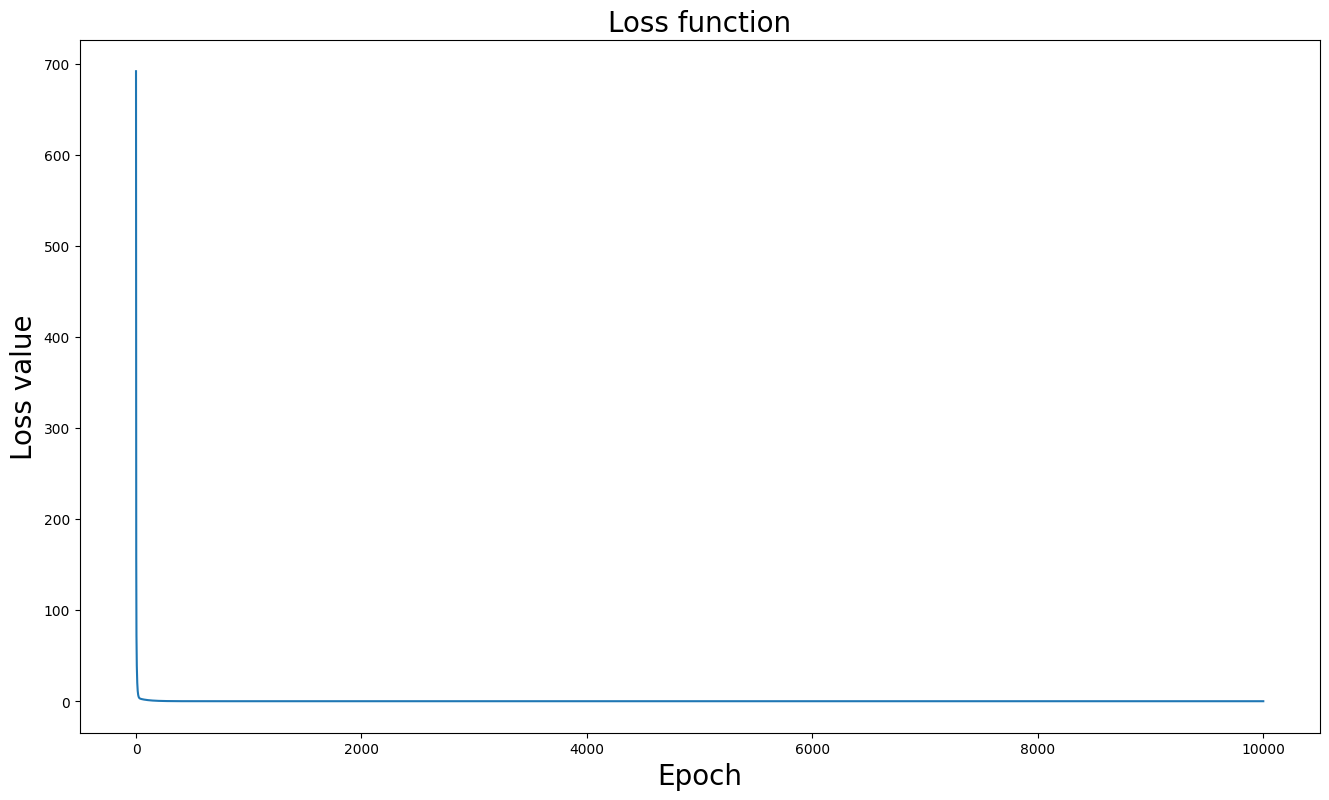

In [ ]:
# Print the loss function
plot(range(epochs), losses)
title('Loss function', size=20)
xlabel('Epoch', size=20)
ylabel('Loss value', size=20)


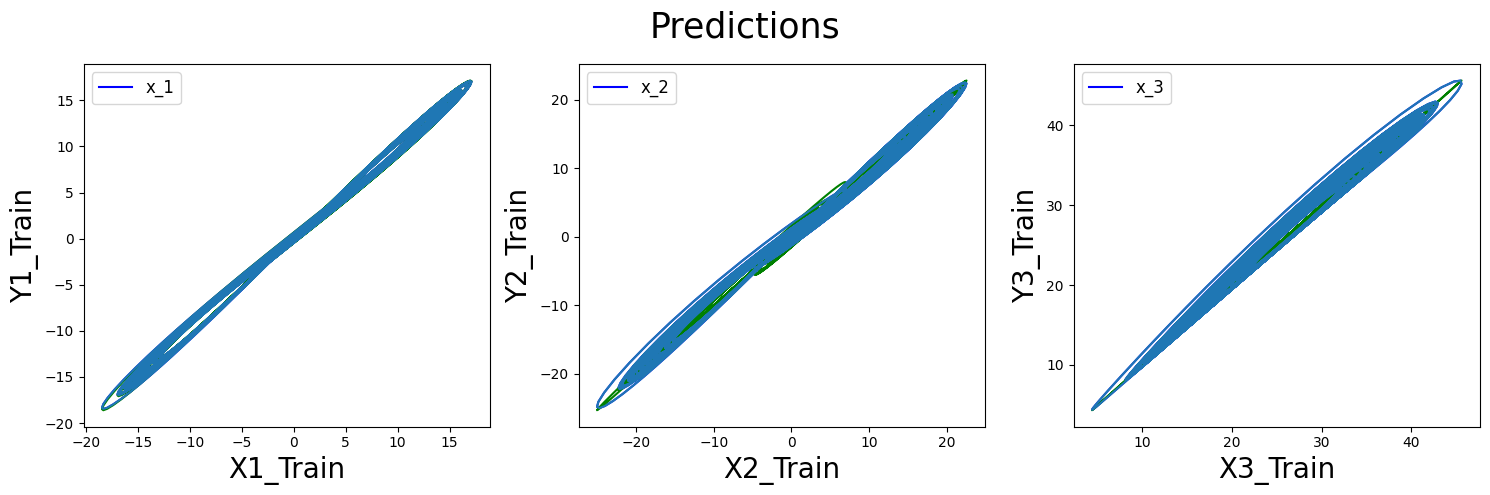

In [ ]:
# Plot
# dt = 0.01
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].plot(x_train[:, i], y_train[:, i],'b')
    axs[i].plot(x_train[:, i], y_pred.detach()[:, i],'g')
    axs[i].set_xlabel(f'X{i + 1}_Train', size=20)
    axs[i].set_ylabel(f'Y{i + 1}_Train', size=20)
    axs[i].plot(x_train[:, i], y_train[:, i])
    axs[i].legend([f'x_{i + 1}'], fontsize=12)
plt.suptitle('Predictions', size=25)
plt.tight_layout()
plt.show()


Slope:  Parameter containing:
tensor([[ 0.8988,  0.0997, -0.0037],
        [-0.1258,  1.0929, -0.0067],
        [-0.0019,  0.0032,  1.0010]], requires_grad=True)
Bias:  Parameter containing:
tensor([ 0.1005,  0.2050, -0.0413], requires_grad=True)


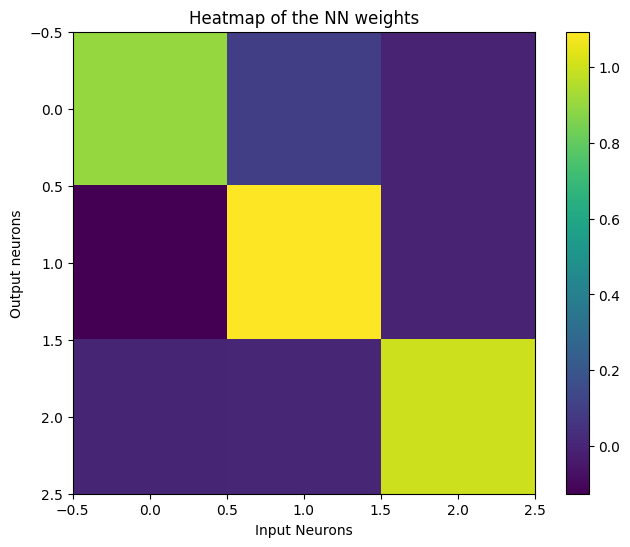

In [ ]:
# Print the model parameters (weights of the neural network)
slope, bias = linear_regression_model.parameters()
print('Slope: ', slope)
print('Bias: ', bias)

plt.figure(figsize=(8, 6))
plt.imshow(slope.detach().numpy(), cmap='viridis', interpolation='none')  # Puedes cambiar el cmap según tus preferencias
plt.colorbar()
plt.title('Heatmap of the NN weights')
plt.xlabel('Input Neurons')
plt.ylabel('Output neurons')
plt.show()


**Response:**

$ x_1(t+dt) = w_{11} \cdot x_1(t) + w_{12}  \cdot x_2(t) +  w_{13} \cdot x_3(t)$

$ x_2(t+dt) = w_{21} \cdot x_1(t) + w_{22} \cdot  x_2(t)+  w_{23} \cdot x_3(t)  $

$ x_3(t+dt) = w_{31} \cdot  x_1(t) + w_{32} \cdot x_2(t)+  w_{33} \cdot x_3(t) $

The M matrix is approximately diagonal, which means the biggest influence for the future value of a variable is their actual value.



**Question 3:**

Now, use a RNN architecture to learn the variations of the time series. To do so, we use the *LSTM()* function from PyTorch. Below, we provide you the dataset and a LSTM class. Here, we recommend that you use GPU acceleration.

After implementing and fitting your RNN, have a look at the estimated parameters: what do they represent? See https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html for more details.

First, we have to rearange the dataset used to train the RNN. We also store the dataset on the GPU.

In [ ]:
# Reshape train and test data (with batch_size = 1)
x_train_LSTM = reshape(x_train, (shape(x_train)[0], 1, shape(x_train)[1]))
x_test_LSTM = reshape(x_test, (shape(x_test)[0], 1, shape(x_test)[1]))
y_train_LSTM = reshape(y_train, (shape(y_train)[0], 1, shape(y_train)[1]))
y_test_LSTM = reshape(y_test, (shape(y_test)[0], 1, shape(y_test)[1]))

# Store the data on the GPU
x_train_LSTM, x_test_LSTM = x_train_LSTM.to(device), x_test_LSTM.to(device)
y_train_LSTM, y_test_LSTM = y_train_LSTM.to(device), y_test_LSTM.to(device)

Then, we suggest to use the following RNN architecture with one LSTM layer and a fully connected layer with linear activation.

In [ ]:
# Declare a class for LSTM
class LSTM_nn(nn.Module):

    # class initialization
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_nn, self).__init__()
        # LSTM layer with 1 hidden layer (hidden_size neurons inside)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers = 1)
        # fully connected layer with linear activation
        self.fc = nn.Linear(hidden_size, output_size)

    # function to apply the neural network
    def forward(self, x):
        out, (h_out, c_out) = self.lstm(x)
        y_pred = self.fc(out)
        return y_pred, h_out, c_out

    # function to apply the neural network (when knowing the hidden state)
    def forward_using_last_hidden_layer(self, x, h, c):
        out, (h_out, c_out) = self.lstm(x, (h, c))
        y_pred = self.fc(out)
        return y_pred, h_out, c_out

In the next cell, we initialize a LSTM with 10 neurons in the hidden layer. Here, we transfer the LSTM model to the GPU.

In [ ]:
# Create the LSTM (3 input size for x and 3 output size for y, 10 neurons in the hidden layer)
model_RNN = LSTM_nn(3, 10, 3)

# Use the GPU to train the model
model_RNN.to(device)

LSTM_nn(
  (lstm): LSTM(3, 10)
  (fc): Linear(in_features=10, out_features=3, bias=True)
)

Then, you will have to optimize the LSTM. We suggest to carrefully check the loss function along the epochs. The number of epoch needed to converge can be large, depending on the optimizer and the learning rate.

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # You can use a different loss function based on your task
optimizer = optim.Adam(model_RNN.parameters(), lr = 0.001)

In [ ]:
# Training loop
epochs = 10000
losses = [] # list to stock the loss at each iteration

for epoch in range(epochs):
    # Forward pass
    y_pred, _, _ = model_RNN(x_train_LSTM)

    # Compute the loss
    loss = criterion(y_pred, y_train_LSTM)
    losses.append(loss.item())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1000/10000], Loss: 93.2252
Epoch [2000/10000], Loss: 45.1029
Epoch [3000/10000], Loss: 22.6972
Epoch [4000/10000], Loss: 11.0406
Epoch [5000/10000], Loss: 4.9930
Epoch [6000/10000], Loss: 2.0175
Epoch [7000/10000], Loss: 0.7755


In [ ]:
# Plot
plot(range(epochs), losses)
title('Loss function')
xlabel('Epoch')
ylabel('Loss ')

In [ ]:
for name, param in model_RNN.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

**Response:**

In the context of an LSTM NN, there are several parameters that are learned during the training process:

- In the LSTM layer:
  - lstm.weight_ih_l0: Input to hidden weights. The size is defined by $[hidden_{size} \cdot 4, input_{size}]$.
  - lstm.weight_hh_l0: Hidden to hidden weights. The size is defined by $[hidden_{size}\cdot 4, hidden_{size}]$.
  - lstm.bias_ih_l0: Biases for the input to hidden connections. The size is defined by $[hidden_{size} \cdot 4]$.
  - lstm.bias_hh_l0: Biases for the hidden to hidden connections. Size: The size is defined by $[hidden_{size} \cdot 4]$.
    
- Fully Connected Layer:
    - fc.weight: Weights for the fully connected layer. The size is defined by $[output_{size} , hidden_{size}]$.
    - fc.bias: Biases for the fully connected layer. The size is defined by $[output_{size}]$.

**Question 4:**

Compare the predictions of the linear regression AR(1) and the LSTM architecture on the test dataset. Compute the root mean squared errors (for each component) between the predicted values and the truth. Plot also the histograms of the residuals (difference between prediction and truth) for the 2 models. What are the main differences between the ouputs of the AR(1) and the RNN models?

First, you have to transfer the prediction of your LSTM from the GPU.

In [ ]:
# Make predictions from the AR1 and LSTM models
y_AR1_hat = model_AR1.forward(x_test)
y_RNN_hat, h_hat, c_hat = model_RNN.forward(x_test_LSTM)

# Transfer data from the GPU
y_RNN_hat = y_RNN_hat.cpu()

In [ ]:
print(y_AR1_hat.shape)
print(y_RNN_hat.shape)
#Caution dimensions
y_RNN_hat = torch.squeeze(y_RNN_hat, dim=1)
print(y_RNN_hat.shape)


In [ ]:
#RMSE__AR1
squared_differences = (y_AR1_hat - y_test) ** 2
mean_squared_differences = squared_differences.mean(axis=0)
rmse = np.sqrt(mean_squared_differences.detach().numpy())
RMSE__AR1=rmse

#RMSE_RNN
squared_differences = (y_RNN_hat - y_test) ** 2
mean_squared_differences = squared_differences.mean(axis=0)
rmse = np.sqrt(mean_squared_differences.detach().numpy())
RMSE_RNN=rmse

print("RMSE__AR1=",RMSE__AR1)
print("RMSE_RNN=",RMSE_RNN)


In [ ]:
Errors_y_AR1_hat= y_AR1_hat-y_test
Errors_y_RNN_hat= y_RNN_hat-y_test


**Response:**

The  AR(1) model has bigger residuals than the RNN, which means the latter does a better prediction.


**Question 5:**

Now, starting from the last value of *y_test*, use the AR(1) model and the RNN to simulate new data (e.g., a sequence of 1500 time steps). You will need to apply the models recursively. Comment the resulting trajectories: do they look like the original ones?

In [ ]:
len_simu = 1500 # length of the simulation
dt = 0.01
x0_AR1 = y_test[-1,:] # initial condition for AR(1)
x0_LSTM = y_test_LSTM[-100:,:,:] # initial condition for LSTM (needed to learn the neurons in the hidden layer)


# Initialize resulting arrays
x_AR1 = torch.zeros((len_simu,3))
x_RNN = torch.zeros((len_simu,3)).to(device)
x_AR1[0,:] = x0_AR1
x_RNN[0,:] = x0_LSTM[-1,:]

# Estimate h and c of the LSTM using several Lorenz times
x_RNN_tmp, h_hat, c_hat = model_RNN.forward(x0_LSTM)

# Loop on the previous prediction
for i in range(len_simu-1):
    x_AR1[i + 1, :] = linear_regression_model.forward(x_AR1[i, :])
    #x_RNN[i+1,:], h_hat, c_hat = model_RNN.forward_using_last_hidden_layer(x_RNN[i,:].reshape(1,1,3), h_hat, c_hat )
    x_RNN[i+1,:], h_hat, c_hat = model_RNN.forward_using_last_hidden_layer(x_RNN[i,:].view(1,1,3), h_hat, c_hat )
print(x_AR1.shape)
# Generate the true run
x_truth = odeint(Lorenz_63, y_test[-1,:], arange(0.01,len_simu*dt,dt), args=(sigma,rho,beta))

In [ ]:
plt.figure(figsize=(15, 10))

# Plot for x1
plt.subplot(3, 1, 1)
plt.plot(x_AR1[:, 0].detach().numpy(), label='AR(1)', c='b')
plt.plot(x_RNN[:, 0].cpu().detach().numpy(), label='RNN', c='g')
plt.plot(x_truth[:, 0], label='Ground truth', linewidth=2,c='r')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Comparison of x1 - AR(1) vs RNN vs True Run')
plt.legend()

# Plot for x2
plt.subplot(3, 1, 2)
plt.plot(x_AR1[:, 1].detach().numpy(), label='AR(1)',  c='b')
plt.plot(x_RNN[:, 1].cpu().detach().numpy(), label='RNN ', c='g')
plt.plot(x_truth[:, 1], label='Ground truth', linewidth=2,c='r')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Comparison of x2 - AR(1) vs RNN vs True Run')
plt.legend()

# Plot for x3
plt.subplot(3, 1, 3)
plt.plot(x_AR1[:, 2].detach().numpy(), label='AR(1) ', c='b')
plt.plot(x_RNN[:, 2].cpu().detach().numpy(), label='RNN ', c='g')
plt.plot(x_truth[:, 2], label='Ground truth', linewidth=2,c='r')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Comparison of x3 - AR(1) vs RNN vs True Run')
plt.legend()

plt.tight_layout()
plt.show()